# PolySphinx Message Size Evaluation

We start with some general definitions of how the packet sizes are calculated. These will be used in the creation of the graphs down below.

In [1]:
from collections import namedtuple
from typing import NamedTuple
from functools import partial
from math import log, ceil, isclose

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

%config InlineBackend.figure_format = 'svg'

In [2]:
# Maximum path length
r = 5
# Default multicast factor
default_p = 5
# Symmetric element size
s_s = 128
# Asymmetric element size
s_a = 256

In [3]:
def unicast(group_size, p, m):
    """Returns the traffic sent by the sender for a multicast message using the naive strategy.
    
    Note that this is also the size that Rollercoaster uses if you count all clients together.
    """
    s_r = 0
    s_f = 0
    s_m = lambda m: m
    return group_size * ((s_a + (2 * r + 2) * s_s) + s_m(m))

In [4]:
PolySphinxParameters = namedtuple("PolySphinxParameters", "s_r s_f s_m")

PolySphinx = PolySphinxParameters(s_r=128, s_f=128 + r * 3, s_m=lambda m: m)

In [5]:
def polysphinx_header(p, level, parameters):
    assert level >= 0
    size_per_hop = 8 + 2 * s_s + parameters.s_r
    if level == 0:
        return s_a + s_s + (r - 1) * size_per_hop + 8 + 3 * s_s + parameters.s_f
    else:
        return (r - 1) * size_per_hop + 8 + p * (s_s + parameters.s_r + polysphinx_header(p, level - 1, parameters))
    
def polysphinx_packet(level, parameters):
    return lambda p, m: polysphinx_header(p, level, parameters) + parameters.s_m(m)

def polysphinx(group_size, p, m, parameters=PolySphinx):
    """Returns the traffic sent by the sender for a multicast message using PolySphinx."""
    # Fill as many messages as we can
    full_messages = group_size // p
    leftover = group_size % p
    # Decide whether the remaining messages are better sent separately or combined
    separate = leftover * polysphinx_packet(0, parameters)(p, m)
    combined = polysphinx_packet(1, parameters)(p, m)
    return full_messages * polysphinx_packet(1, parameters)(p, m) + min(separate, combined)

def polysphinx_unicast(group_size, p, m, parameters=PolySphinx):
    """Unicast but with PolySphinx l=0 packets instead of Sphinx packets."""
    return group_size * polysphinx_packet(0, parameters)(p, m)

# Bandwidth Comparison

In [6]:
class Bandwidth(NamedTuple):
    sphinx_total: float
    sphinx_goodput: float
    polysphinx_total: float
    polysphinx_goodput: float
        
        
def compute_bandwidth_usage(p, psi, lambda_p, lambda_l, lambda_d, payload_size):
    """Computes the bandwidth for a single set of parameters.
    
    :param p: The replication factor.
    :param psi: The share of multicast traffic.
    :param lambda_p: The sending frequency for payload messages.
    :param lambda_l: The sending frequency for loop messages.
    :param lambda_d: The sending frequency for drop messages.
    :param payload_size: The size of the payload.
    """
    lambda_total = lambda_p + lambda_l + lambda_d
    
    size_sphinx = unicast(1, 1, payload_size)
    size_uni = polysphinx_unicast(1, 1, payload_size)
    size_poly = polysphinx_packet(1, PolySphinx)(p, payload_size)

    lambda_poly = psi * lambda_total
    lambda_uni = lambda_total - lambda_poly

    lambda_poly_p = psi * lambda_p
    lambda_uni_p = lambda_p - lambda_poly_p

    ps_total = lambda_uni * size_uni + lambda_poly * size_poly
    ps_goodput = lambda_uni_p * payload_size + lambda_poly_p * payload_size * p
    
    sphinx_total = lambda_total * size_sphinx
    sphinx_goodput = lambda_p * payload_size
    
    return Bandwidth(
        sphinx_total=sphinx_total,
        sphinx_goodput=sphinx_goodput,
        polysphinx_total=ps_total,
        polysphinx_goodput=ps_goodput,
    )


def compute_bandwidth_comparison(p, lambda_p, lambda_l, lambda_d, payload_size):
    """Computes a series of PolySphinx bandwidths by varying the multicast share.
    
    For the parameters, see :func:`compute_bandwidth_usage`.
    
    Returns a tuple with three elements:
    
    * The series of ``psi`` values.
    * The series of total bandwidths.
    * The series of goodputs achieved.
    """
    psis = [x / 100 for x in range(0, 101, 5)]
    psis = np.linspace(0.0, 1.0, 20)
    # psi is the share of PolySphinx messages
    bandwidths = []
    goodputs = []        
    
    for psi in psis:
        bw = compute_bandwidth_usage(p, psi, lambda_p, lambda_l, lambda_d, payload_size)
        
        bandwidths.append(bw.polysphinx_total)
        goodputs.append(bw.polysphinx_goodput)
        
    return (psis, bandwidths, goodputs)

In [7]:
class MessageRates(NamedTuple):
    sphinx_total: float
    sphinx_payload: float
    polysphinx_total: float
    polysphinx_payload: float
        

def compute_message_rates(p, psi, bandwidth_limit, payload_size):
    """Computes the message rates that can be achieved given the bandwidth limit.
    
    :param p: The replication factor.
    :param psi: The share of multicast traffic.
    :param bandwidth_limit: The bandwidth limit.
    :param payload_size: The payload size.
    """
    size_sphinx = unicast(1, 1, payload_size)
    size_uni = polysphinx_unicast(1, 1, payload_size)
    size_poly = polysphinx_packet(1, PolySphinx)(p, payload_size)
    
    lambda_total = bandwidth_limit / (psi * size_poly + (1 - psi) * size_uni)
    lambda_poly = lambda_total * psi
    lambda_uni = lambda_total - lambda_poly
    good_ratio = 1 / 3

    return MessageRates(
        sphinx_total=bandwidth_limit / size_sphinx,
        sphinx_payload=good_ratio * (bandwidth_limit / size_sphinx),
        polysphinx_total=lambda_total,
        polysphinx_payload=(lambda_uni * good_ratio + lambda_poly * good_ratio * p),
    )


def compute_message_count_comparison(p, bandwidth_limit, payload_size):
    """Computes the message rate comparison by varying the share of multicast traffic.
    
    For the parameters, see :func:`compute_message_rates`.
    
    Returns a tuple with three elements:
    
    * The ``psi`` values for which the rates have been computed.
    * The total message rates for those psi values.
    * The payload message rates for those psi values.
    """
    psis = [x / 100 for x in range(0, 101, 5)]
    psis = np.linspace(0.0, 1.0, 20)
    # psi is the share of PolySphinx messages
    total_messages = []
    payload_messages = []        
    
    for psi in psis:
        rate = compute_message_rates(p, psi, bandwidth_limit, payload_size)
        
        total_messages.append(rate.polysphinx_total)
        payload_messages.append(rate.polysphinx_payload)
        
    return (psis, total_messages, payload_messages)

The following is Figure 5 in Section 8.2 in the paper:

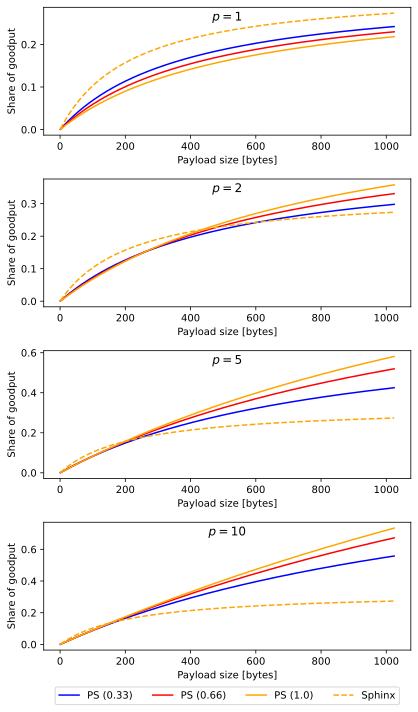

In [8]:
def plot_stacked_goodput_comparison():
    fig, axes = plt.subplots(4, 1, figsize=(6, 10))
    ps = [1, 2, 5, 10]
    psis = [0.33, 0.66, 1.00]
    colors = ["blue", "red", "orange"]
    payload_sizes = np.arange(1 * 8, 1024 * 8 + 1, 1)
    for p, ax in zip(ps, axes):
        for psi, linecolor in zip(psis, colors):
            data = [
                compute_bandwidth_usage(p, psi, 2, 2, 2, payload_size)
                for payload_size
                in payload_sizes
            ]
            ax.plot(
                payload_sizes / 8,
                [d.polysphinx_goodput / d.polysphinx_total for d in data],
                label=f"PS (${psi}$)",
                color=linecolor,
            )

        baseline = [compute_bandwidth_usage(p, psi, 2, 2, 2, payload_size) for payload_size in payload_sizes]
        ax.plot(
            payload_sizes / 8,
            [b.sphinx_goodput / b.sphinx_total for b in baseline],
            label=f"Sphinx",
            linestyle="--",
            color=colors[-1],
        )
            
        ax.set_title(f"$p = {p}$", y=0.85)
        ax.set_ylabel("Share of goodput")
        ax.set_xlabel("Payload size [bytes]")
        if p == ps[-1]:
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=4)

    fig.tight_layout()
    return fig


if __name__ == "__main__":
    plot_stacked_goodput_comparison().savefig("size-graphs/stacked_goodput_comparison.pdf")

Figure 7 in Appendix C:

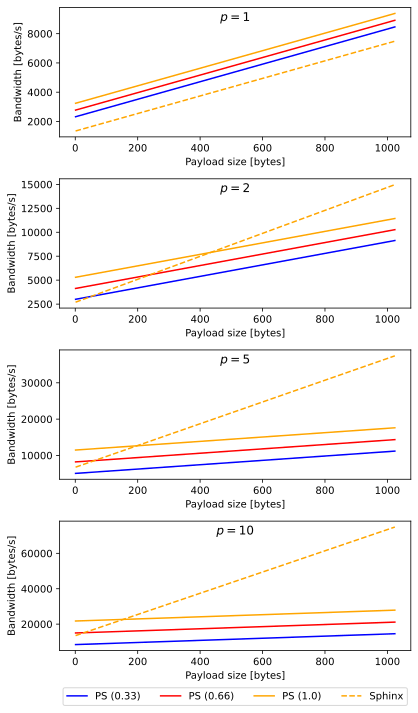

In [9]:
def plot_stacked_bandwidth_comparison():
    fig, axes = plt.subplots(4, 1, figsize=(6, 10))
    ps = [1, 2, 5, 10]
    psis = [0.33, 0.66, 1.00]
    colors = ["blue", "red", "orange"]
    payload_sizes = np.arange(1 * 8, 1024 * 8, 1)
    for p, ax in zip(ps, axes):
        for psi, linecolor in zip(psis, colors):
            data = [
                compute_bandwidth_usage(p, psi, 2, 2, 2, payload_size)
                for payload_size
                in payload_sizes
            ]
            ax.plot(
                payload_sizes / 8,
                [d.polysphinx_total / 8 for d in data],
                label=f"PS (${psi}$)",
                color=linecolor,
            )

        baseline = [compute_bandwidth_usage(1, psi, 2 * p, 2 * p, 2 * p, payload_size) for payload_size in payload_sizes]
        ax.plot(
            payload_sizes / 8,
            [b.sphinx_total / 8 for b in baseline],
            label=f"Sphinx",
            linestyle="--",
            color=colors[-1],
        )
            
        ax.set_title(f"$p = {p}$", y=0.85)
        ax.set_ylabel("Bandwidth [bytes/s]")
        ax.set_xlabel("Payload size [bytes]")
        if p == ps[-1]:
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=4)

    fig.tight_layout()
    return fig


if __name__ == "__main__":
    plot_stacked_bandwidth_comparison().savefig("size-graphs/stacked_bandwidth_comparison.pdf")

The following plot is Figure 8 in Appendix C:

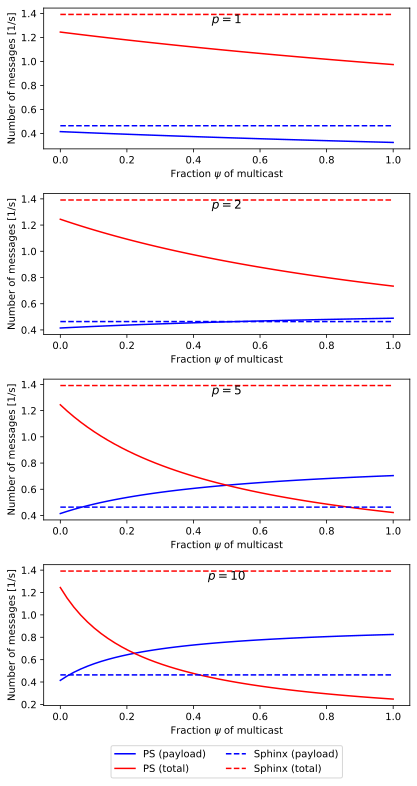

In [10]:
def plot_message_rate_stacked():
    bandwidth_limit = 1024 * 8
    fig, axes = plt.subplots(4, 1, figsize=(6, 11))
    
    psis = np.linspace(0.0, 1.0, 50)
    ps = [1, 2, 5, 10]
    payload_size = 512 * 8
    
    for p, ax in zip(ps, axes):
        rates = [
            compute_message_rates(p, psi, bandwidth_limit, payload_size)
            for psi
            in psis
        ]
        ax.plot(
            psis,
            [x.polysphinx_payload for x in rates],
            label=f"PS (payload)",
            color="blue",
        )
        ax.plot(
            psis,
            [x.polysphinx_total for x in rates],
            label=f"PS (total)",
            color="red",
        )
        ax.plot(
            psis,
            [x.sphinx_payload for x in rates],
            label=f"Sphinx (payload)",
            linestyle="--",
            color="blue",
        )
        ax.plot(
            psis,
            [x.sphinx_total for x in rates],
            label=f"Sphinx (total)",
            linestyle="--",
            color="red",
        )
            
        ax.set_title(f"$p = {p}$", y=0.85)
        ax.set_ylabel("Number of messages [1/s]")
        ax.set_xlabel("Fraction $\\psi$ of multicast")
        if p == ps[-1]:
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=2)

    fig.tight_layout()
    return fig


if __name__ == "__main__":
    plot_message_rate_stacked().savefig("size-graphs/message_count_stacked.pdf")

The following plot is Figure 9 in Appendix C:

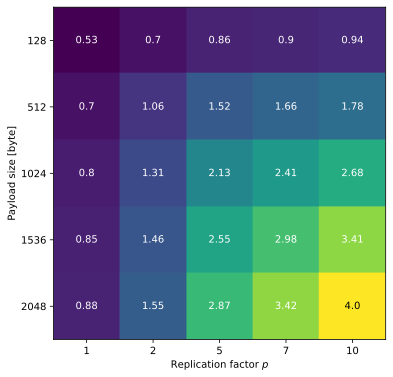

In [11]:
def plot_message_rate_increase_heatmap():
    bandwidth_limit = 1024 * 8
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    cols = []
    payload_sizes = [128 * 8, 512 * 8, 1024 * 8, 1536 * 8, 2 * 1024 * 8]
    ps = [1, 2, 5, 7, 10]
    for payload_size in payload_sizes:
        row = []
        for p in ps:
            rate = compute_message_rates(p, 1.0, bandwidth_limit, payload_size)
            increase = rate.polysphinx_payload / rate.sphinx_payload
            row.append(increase)
        cols.append(row)
    arr = np.array(cols)
    
    ax.imshow(arr)
    
    for y in range(len(payload_sizes)):
        for x in range(len(ps)):
            color = "w" if arr[y, x] < 4 else "k"
            ax.text(x, y, round(arr[y, x], 2), ha="center", va="center", color=color)
    
    ax.set_xlabel("Replication factor $p$")
    ax.set_xticks(np.arange(len(ps)), labels=ps)
    ax.set_ylabel("Payload size [byte]")
    ax.set_yticks(np.arange(len(payload_sizes)), labels=[p // 8 for p in payload_sizes])
    return fig


if __name__ == "__main__":
    plot_message_rate_increase_heatmap().savefig("size-graphs/message_count_increase_heatmap.pdf")

Figure 10 in Appendix C:

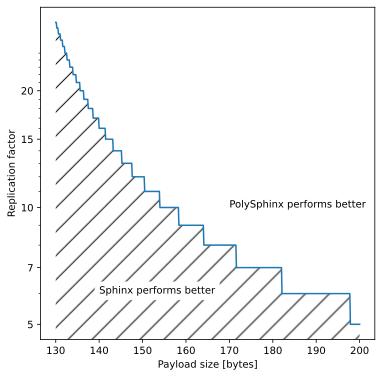

In [12]:
def compute_p_breakpoint(payload_size=1, psi=1, lambda_p=2, lambda_l=2, lambda_d=2):
    p = 2
    while True:
        bandwidth = compute_bandwidth_usage(p, psi, lambda_p, lambda_l, lambda_d, payload_size)
        sphinx_goodput = bandwidth.sphinx_goodput / bandwidth.sphinx_total
        poly_goodput = bandwidth.polysphinx_goodput / bandwidth.polysphinx_total
        if poly_goodput > sphinx_goodput:
            return p
        p += 1
        if p > 256:
            return None
        
def plot_p_breakpoints():
    payload_sizes = np.arange(130 * 8, 200 * 8 + 1, 1)
    breakpoints = [compute_p_breakpoint(payload_size) for payload_size in payload_sizes]
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(payload_sizes / 8, breakpoints)
    ax.set_ylabel("Replication factor")
    ax.set_xlabel("Payload size [bytes]")
    ax.set_yscale("log")
    ax.text(140, 6, "Sphinx performs better", backgroundcolor="white")
    ax.text(170, 10, "PolySphinx performs better")
    
    tics = list(range(5, 26))
    ax.set_yticks(tics, labels=["" for _ in tics], minor=True)
    tics = [2, 5, 7, 10, 15, 20]
    ax.set_yticks(tics, labels=[str(t) for t in tics], minor=False)
    ax.fill_between(payload_sizes / 8, np.array(breakpoints), facecolor="w", hatch="/")
    return fig
    
if __name__ == "__main__":
    plot_p_breakpoints().savefig("size-graphs/breakpoint_p.pdf")

## Message Rate Calculation

With the following, we compute the message rates for our latency evaluation.

We assume the standard Rollercoaster payload split of 1/3 (2 payload messages to 2 drop and 2 loop messages).

In [13]:
def get_simulation_parameters():
    def print_rate(rate):
        for name in ["user_rate_payload", "user_rate_drop", "user_rate_loop"]:
            print(f"'{name}': {rate},")

    payload_size = 3 * 1024 * 8
    # The standard Rollercoaster scenario sends 6 message per second, so let's try to hit that
    bandwidth_limit = unicast(1, 1, payload_size) * 6
    print(f"Bandwidth limit: {bandwidth_limit}")
    p = 5
    rates = compute_message_rates(
        p=p,
        # psi = 1 because we want to look at the pure multicast case, like the previous simulation
        psi=1,
        bandwidth_limit=bandwidth_limit,
        payload_size=payload_size,
    )
    
    rates_2 = compute_message_rates(
        p=2,
        psi=1,
        bandwidth_limit=bandwidth_limit,
        payload_size=payload_size,
    )
    
    # We deal with messages/second, the simulator deals with
    # seconds between messages, so we need to take the inverse:
    print("Unicast & Rollercoaster:")
    print_rate(rates.sphinx_total / 3)
    print("PolySphinx (p=2):")
    print_rate(rates_2.polysphinx_total / 3)
    print(f"PolySphinx (p={p}):")
    print_rate(rates.polysphinx_total / 3)
    
if __name__ == "__main__":
    get_simulation_parameters()

Bandwidth limit: 158208
Unicast & Rollercoaster:
'user_rate_payload': 2.0,
'user_rate_drop': 2.0,
'user_rate_loop': 2.0,
PolySphinx (p=2):
'user_rate_payload': 1.6668563120298376,
'user_rate_drop': 1.6668563120298376,
'user_rate_loop': 1.6668563120298376,
PolySphinx (p=5):
'user_rate_payload': 1.3227983043620035,
'user_rate_drop': 1.3227983043620035,
'user_rate_loop': 1.3227983043620035,


## Extra Plots

The following plots are not part of the paper, but are provided as additional information:

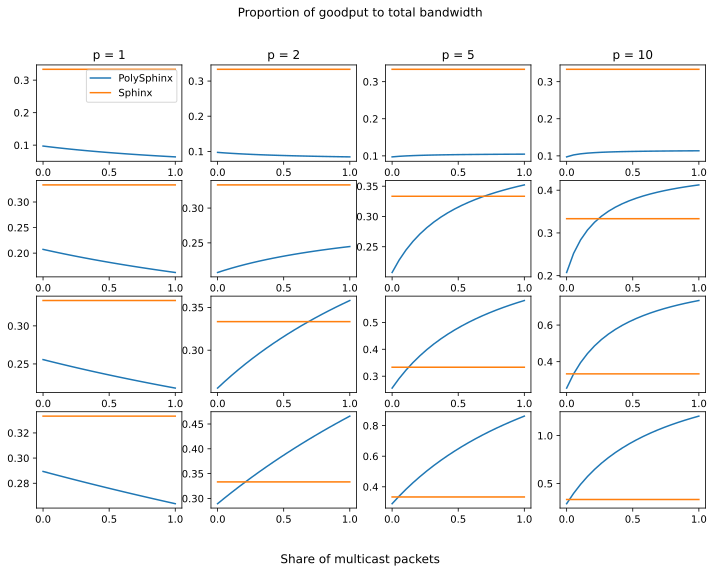

In [14]:
def plot_proportion_array():
    bandwidth_limit = 1024 * 8
    fig, axes = plt.subplots(4, 4, figsize=(12, 8))
    
    for x, p in enumerate([1, 2, 5, 10]):
        for y, payload_size in enumerate([128 * 8, 512 * 8, 1024 * 8, 2 * 1024 * 8]):
            ax = axes[y, x]
            psis, bandwidth, goodput = compute_bandwidth_comparison(
                p, 2, 2, 2, payload_size)
            if y == 0:
                ax.set_title(f"p = {p}")
            ax.plot(psis, [gp / bw for bw, gp in zip(bandwidth, goodput)], label="PolySphinx")
            
            
            size_uni = unicast(1, 1, payload_size)
            sphinx_bw = []
            for psi in psis:
                lambda_uni = 2 + 2 + 2
                lambda_uni_p = 2

                sphinx_bw.append(lambda_uni_p * size_uni / (lambda_uni * size_uni))
            ax.plot(psis, sphinx_bw, label="Sphinx")
            
            if (x, y) == (0, 0):
                ax.legend()
            
    fig.suptitle("Proportion of goodput to total bandwidth")
    fig.supxlabel("Share of multicast packets")
    return fig


if __name__ == "__main__":
    plot_proportion_array().savefig("size-graphs/array_goodput_comparison.pdf")

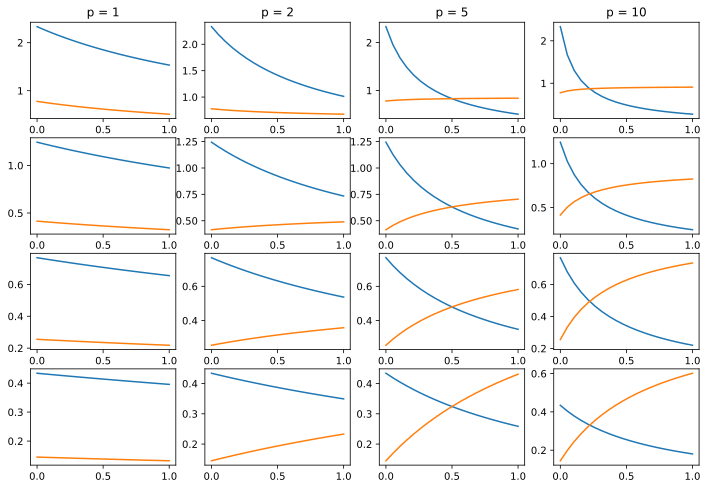

In [15]:
def plot_message_rate_array():
    bandwidth_limit = 1024 * 8
    fig, axes = plt.subplots(4, 4, figsize=(12, 8))
    
    for x, p in enumerate([1, 2, 5, 10]):
        for y, payload_size in enumerate([128 * 8, 512 * 8, 1024 * 8, 2 * 1024 * 8]):
            ax = axes[y, x]
            psis, total_messages, payload_messages = compute_message_count_comparison(
                p, bandwidth_limit, payload_size)
            if y == 0:
                ax.set_title(f"p = {p}")
            ax.plot(psis, total_messages)
            ax.plot(psis, payload_messages)


if __name__ == "__main__":
    plot_message_rate_array()

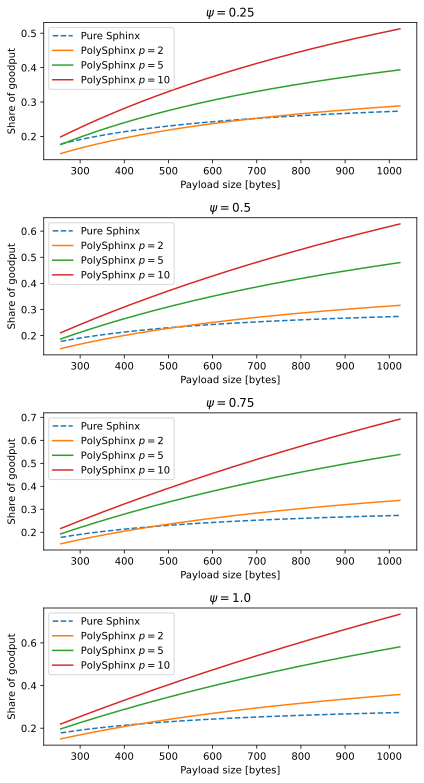

In [16]:
def plot_stacked_goodput_comparison_2():
    fig, axes = plt.subplots(4, 1, figsize=(6, 11))
    psis = [0.25, 0.50, 0.75, 1.00]
    payload_sizes = np.arange(256 * 8, 1024 * 8 + 1, 8)
    for psi, ax in zip(psis, axes):
        baseline = [compute_bandwidth_usage(0, 0, 2, 2, 2, payload_size) for payload_size in payload_sizes]
        ax.plot(
            payload_sizes / 8,
            [b.sphinx_goodput / b.sphinx_total for b in baseline],
            label="Pure Sphinx",
            linestyle="--",
        )
        for p in [2, 5, 10]:
            data = [
                compute_bandwidth_usage(p, psi, 2, 2, 2, payload_size)
                for payload_size
                in payload_sizes
            ]
            ax.plot(
                payload_sizes / 8,
                [d.polysphinx_goodput / d.polysphinx_total for d in data],
                label=f"PolySphinx $p = {p}$",
            )
        ax.set_title(f"$\psi = {psi}$")
        ax.set_ylabel("Share of goodput")
        ax.set_xlabel("Payload size [bytes]")
        ax.legend()
            
    fig.tight_layout()
    return fig


if __name__ == "__main__":
    plot_stacked_goodput_comparison_2()

## Breakpoint Values

In [17]:
def compute_breakpoint(p=2, psi=1, lambda_p=2, lambda_l=2, lambda_d=2):
    payload_sizes = np.arange(1 * 8, 2048 * 8 + 1, 8)
    for payload_size in payload_sizes:
        bandwidth = compute_bandwidth_usage(p, psi, lambda_p, lambda_l, lambda_d, payload_size)
        sphinx_goodput = bandwidth.sphinx_goodput / bandwidth.sphinx_total
        poly_goodput = bandwidth.polysphinx_goodput / bandwidth.polysphinx_total
        if poly_goodput > sphinx_goodput:
            return payload_size
        
def show_breakpoint(p=2, psi=1, lambda_p=2, lambda_l=2, lambda_d=2):
    breakpoint = compute_breakpoint(p, psi, lambda_p, lambda_l, lambda_d)
    # Convert bits to bytes
    breakpoint = int(ceil(breakpoint / 8))
    print(f"Breakpoint for p={p} and psi={psi:.2f} is at {breakpoint}")
        
if __name__ == "__main__":
    show_breakpoint(p=2, psi=1)
    show_breakpoint(p=5, psi=1)

Breakpoint for p=2 and psi=1.00 is at 435
Breakpoint for p=5 and psi=1.00 is at 198
